## CS310 Natural Language Processing
## Assignment 2. Word2vec Implementation 

**Total points**: 50

Train a word2vec model using the **skip-gram** architecture and **negative sampling**.

You should roughtly follow the structure of the notebook. Add additional cells if you feel needed. 

You can (and you should) re-use the code from *Lab 4 (part 2): Data preparation for implementing word2vec*. 

Make sure your code is readable and well-structured.

### 0. Import Necessary Libraries

In [7]:
from typing import List
from utils import CorpusReader
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

## 1. Data Processing

The corpus data is in `lunyu_20chapters.txt`. Use the `CorpusReader` class in `utils.py` to help you.

In [8]:
# Read raw data in lunyu_20chapters.txt

### YOUR CODE HERE ###
corpus = CorpusReader(inputFileName="lunyu_20chapters.txt", min_count=1)

# 读取原始文本并分词
with open("lunyu_20chapters.txt", 'r', encoding='utf-8') as f:
    text = f.read()
    words = text.split()  # 简单分词

# 过滤掉不在词典中的词
words = [word for word in words if word in corpus.word2id]
print(f"Total words in text: {len(words)}")
print(f"Vocabulary size: {corpus.vocab_size}")
### END YOUR CODE ###

Total vocabulary: 1352
Total words in text: 0
Vocabulary size: 1352


In [9]:
# Re-use the code from lab with necessary modifications

def generate_data(words: List[str], window_size: int, k: int, corpus: CorpusReader):
    """ Generate the training data for word2vec skip-gram model
    Args:
        text: the input text
        window_size: the size of the context window
        k: the number of negative samples
        corpus: the corpus object, providing utilities such as word2id, getNegatives, etc.
    """
    ### YOUR CODE HERE ###
    data = []
    # 使用词典大小作为负采样的范围
    vocab_size = len(corpus.word2id)
    
    for i, center_word in enumerate(corpus.word2id):
        
        if center_word not in corpus.word2id:
            continue
            
        center_id = corpus.word2id[center_word]
        # 获取上下文窗口
        window_start = max(0, i - window_size)
        window_end = min(len(words), i + window_size + 1)
        
        # 对窗口内的每个上下文词
        for j in range(window_start, window_end):
            if i != j:  # 跳过中心词自身
                context_word = words[j]
                if context_word not in corpus.word2id:
                    continue
                    
                outside_id = corpus.word2id[context_word]
                # 获取负样本
                negative_ids = corpus.getNegatives(center_id, k)
                # 确保negative_ids是numpy数组
                negative_ids = np.array(negative_ids, dtype=np.int64)
                
                data.append((center_id, outside_id, negative_ids))
    
    return data
    ### END YOUR CODE ###

def batchify(data: List, batch_size: int):
    """ Group a stream into batches and yield them as torch tensors.
    Args:
        data: a list of tuples
        batch_size: the batch size 
    Yields:
        a tuple of three torch tensors: center, outside, negative
    """
    assert batch_size < len(data) # data should be long enough
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        if i > len(data) - batch_size: # if the last batch is smaller than batch_size, pad it with the first few data
            batch = batch + data[:i + batch_size - len(data)]
        
        ### YOUR CODE HERE ###
        # 预先创建numpy数组，然后一次性转换为tensor
        center_words = np.array([item[0] for item in batch])
        outside_words = np.array([item[1] for item in batch])
        # 对于negative samples，需要特别处理因为它是二维的
        negative_samples = np.array([item[2] for item in batch])
        
        # 转换为tensor
        center_tensor = torch.LongTensor(center_words)
        outside_tensor = torch.LongTensor(outside_words)
        negative_tensor = torch.LongTensor(negative_samples)
        
        yield center_tensor, outside_tensor, negative_tensor
        ### END YOUR CODE ###

## 2. Define the Model

In [10]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(SkipGram, self).__init__()
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        # 将sparse参数设为False
        self.emb_v = nn.Embedding(vocab_size, emb_size, sparse=False)
        self.emb_u = nn.Embedding(vocab_size, emb_size, sparse=False)

        initrange = 1.0 / self.emb_size
        nn.init.uniform_(self.emb_v.weight.data, -initrange, initrange)
        nn.init.constant_(self.emb_u.weight.data, 0)# same outcome as self.emb_u.weight.data.zero_()

    def forward(self, center, outside, negative):
        """
        Args:
            center: the center word indices (B, )
            outside: the outside word indices (B, )
            negative: the negative word indices (B, k)
        """
        v_c = self.emb_v(center)
        u_o = self.emb_u(outside)
        u_n = self.emb_u(negative)
        
        ### YOUR CODE HERE ###
        # Compute positive score
        pos_score = torch.sum(v_c * u_o, dim=1)  # (B,)
        pos_score = torch.clamp(pos_score, min=-10, max=10)  # 防止数值溢出
        pos_loss = F.logsigmoid(pos_score)  # (B,)
        
        # Compute negative score
        # reshape v_c to (B, 1, emb_size) for broadcasting
        neg_score = torch.bmm(u_n, v_c.unsqueeze(2)).squeeze()  # (B, k)
        neg_score = torch.clamp(neg_score, min=-10, max=10)  # 防止数值溢出
        neg_loss = F.logsigmoid(-neg_score).sum(dim=1)  # (B,)
        
        # Total loss
        loss = -(pos_loss + neg_loss).mean()
        # Hint: torch.clamp the input to F.logsigmoid to avoid numerical underflow/overflow
        ### END YOUR CODE ###

        return loss
    
    def save_embedding(self, id2word, file_name):
        embedding = self.emb_v.weight.cpu().data.numpy()
        with open(file_name, 'w') as f:
            f.write('%d %d\n' % (len(id2word), self.emb_size))
            for wid, w in id2word.items():
                e = ' '.join(map(lambda x: str(x), embedding[wid]))
                f.write('%s %s\n' % (w, e))

## 3. Train and Evaluate

Total vocabulary: 1352
Using device: cpu
生成训练数据...
生成了 13490 个训练样本
Epoch 1, Batch 100, Loss: 6.6311
Epoch 1, Batch 200, Loss: 4.3133
Epoch 1, Batch 300, Loss: 3.9660
Epoch 1, Batch 400, Loss: 3.8886
Epoch 1, Batch 500, Loss: 3.4072
Epoch 1, Batch 600, Loss: 3.1201
Epoch 1, Batch 700, Loss: 2.7949
Epoch 1, Batch 800, Loss: 2.4188
Epoch 1 完成。当前学习率: 0.022500
Epoch 2, Batch 100, Loss: 1.2622
Epoch 2, Batch 200, Loss: 1.1708
Epoch 2, Batch 300, Loss: 1.1466
Epoch 2, Batch 400, Loss: 1.1682
Epoch 2, Batch 500, Loss: 1.1218
Epoch 2, Batch 600, Loss: 1.2859
Epoch 2, Batch 700, Loss: 1.3259
Epoch 2, Batch 800, Loss: 1.3821
Epoch 2 完成。当前学习率: 0.020250
Epoch 3, Batch 100, Loss: 0.7366
Epoch 3, Batch 200, Loss: 0.7487
Epoch 3, Batch 300, Loss: 0.7054
Epoch 3, Batch 400, Loss: 0.8310
Epoch 3, Batch 500, Loss: 0.8476
Epoch 3, Batch 600, Loss: 0.8554
Epoch 3, Batch 700, Loss: 0.8628
Epoch 3, Batch 800, Loss: 0.8049
Epoch 3 完成。当前学习率: 0.018225
Epoch 4, Batch 100, Loss: 0.5590
Epoch 4, Batch 200, Loss: 0

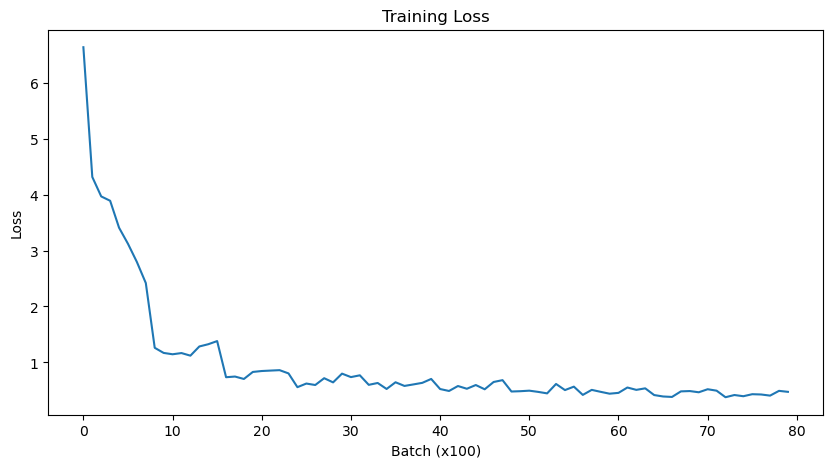

In [11]:
def train(model, words, corpus, batch_size, window_size, k, optimizer, scheduler, 
          epochs, device='cpu', print_interval=100):
    model.to(device)
    losses = []
    
    try:
        # 生成训练数据
        print("生成训练数据...")
        train_data = generate_data(words, window_size, k, corpus)
        print(f"生成了 {len(train_data)} 个训练样本")
        
        if len(train_data) == 0:
            raise ValueError("没有生成任何训练数据！")
            
        for epoch in range(epochs):
            total_loss = 0
            batch_count = 0
            
            # 打乱训练数据
            np.random.shuffle(train_data)
            
            # 创建批次
            for center, outside, negative in batchify(train_data, batch_size):
                try:
                    # 移动数据到设备
                    center = center.to(device)
                    outside = outside.to(device)
                    negative = negative.to(device)
                    
                    # 前向传播
                    optimizer.zero_grad()
                    loss = model(center, outside, negative)
                    
                    # 反向传播
                    loss.backward()
                    
                    # 使用更温和的梯度裁剪方式
                    for param in model.parameters():
                        if param.grad is not None:
                            param.grad.data.clamp_(-1, 1)
                    
                    optimizer.step()
                    
                    total_loss += loss.item()
                    batch_count += 1
                    
                    if batch_count % print_interval == 0:
                        avg_loss = total_loss / print_interval
                        print(f"Epoch {epoch+1}, Batch {batch_count}, Loss: {avg_loss:.4f}")
                        losses.append(avg_loss)
                        total_loss = 0
                        
                except RuntimeError as e:
                    print(f"批次训练出错: {e}")
                    continue
            
            scheduler.step()
            print(f"Epoch {epoch+1} 完成。当前学习率: {scheduler.get_last_lr()[0]:.6f}")
            
    except Exception as e:
        print(f"训练过程出错: {e}")
        raise
        
    return losses


# Suggested hyperparameters
initial_lr = 0.025
batch_size = 16
emb_size = 50
window_size = 5
k = 10 # the number of negative samples, change with your own choice for better embedding performance
min_count = 1 # because our data is small. If min_count > 1, you should filter out those unknown words from the data in train() function
# optimizer = torch.optim.Adam() # or torch.optim.SparseAdam()
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR() # or torch.optim.lr_scheduler.StepLR()

# Initialize the corpus and model
corpus = CorpusReader('lunyu_20chapters.txt', min_count)
vocab_size = corpus.vocab_size
model = SkipGram(vocab_size, emb_size)

# Initialize optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)  # 使用更简单的学习率调度
# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



# 使用修改后的函数进行训练
epochs = 10
losses = train(model, corpus.id2word, corpus, batch_size, window_size, k, optimizer, scheduler, 
              epochs, device=device, print_interval=100)



# Plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Batch (x100)')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.savefig('loss_curve.png')
plt.show()

### Hints: ###
# - If you have cuda-supported GPUs, you can run the training faster by
#   `device = torch.device("cuda" if self.use_cuda else "cpu")`
#   `model.cuda()`
#   You also need to move all tensor data to the same device
# - If you find Inf or NaN in the loss, you can try to clip the gradient usning `torch.nn.utils.clip_grad_norm_`
# - Remember to save the embeddings when training is done

## 4. Save the Embeddings


Save the embeddings into a `gensim` compatible format.

In [ ]:
output_file = 'embeddings.txt'


weights = model.emb_v.weight.detach().cpu().numpy()
with open(output_file, "w") as f:
    f.write(f"{vocab_size} {emb_size}\n")  # First line: vocab size and vector dimension
    for idx in range(vocab_size):
        if idx in corpus.id2word:  # 确保索引在id2word中存在
            word = corpus.id2word[idx]
            vector_str = " ".join(map(str, weights[idx]))
            f.write(f"{word} {vector_str}\n")

## 5. Plot and Compare Embeddings

Use `sklearn.decomposition.TruncatedSVD` to reduce the dimensionality of the obtained embeddings to 2 and plot the selected words in 2D space.

*Hint*:
- Obtain the embeddings into a numpy array by `model.emb_v.cpu().data.numpy()`
- The word2id dictionary is in `model.word2id`
- If you are trying to load from a saved embedding file, you can use the APIs from `gensim`.
  - For exmaple, `model = gensim.models.KeyedVectors.load_word2vec_format('path/to/file')`
  - Check out the documentation for more details: https://radimrehurek.com/gensim/models/keyedvectors.html

In [14]:
# Load embeddings
### YOUR CODE HERE ###
embeddings = model.emb_v.weight.detach().cpu().numpy()
id2word = corpus.id2word
word2id = corpus.word2id
### END YOUR CODE ###

In [15]:
# Truncated SVD
### YOUR CODE HERE ###
svd = TruncatedSVD(n_components=2)
embeddings_2d = svd.fit_transform(embeddings)

print(f"Explained variance ratio: {svd.explained_variance_ratio_.sum():.2f}")
### END YOUR CODE ###

Explained variance ratio: 0.06


/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_98514/2642123087.py:23: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from current font.
  plt.savefig(f'word_embeddings_emb{emb_size}_win{window_size}_k{k}.png')
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_98514/2642123087.py:23: UserWarning: Glyph 20064 (\N{CJK UNIFIED IDEOGRAPH-4E60}) missing from current font.
  plt.savefig(f'word_embeddings_emb{emb_size}_win{window_size}_k{k}.png')
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_98514/2642123087.py:23: UserWarning: Glyph 26352 (\N{CJK UNIFIED IDEOGRAPH-66F0}) missing from current font.
  plt.savefig(f'word_embeddings_emb{emb_size}_win{window_size}_k{k}.png')
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_98514/2642123087.py:23: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from current font.
  plt.savefig(f'word_embeddings_emb{emb_size}_win{window_size}_k{k}.png')
/var/folders/_4/v6wmn5j14xb7tmgn

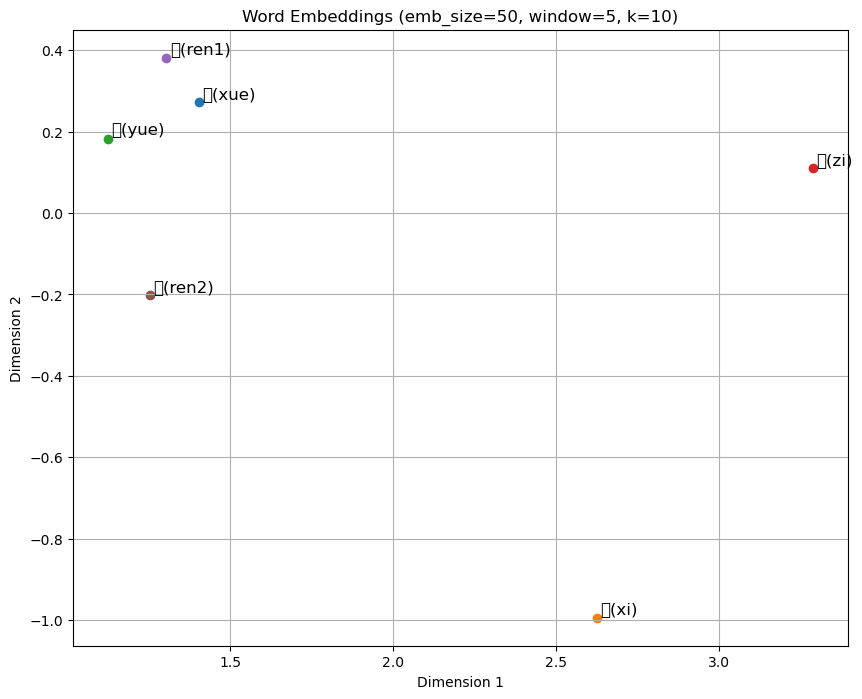

In [17]:
# Plot the following words or other words you are interested in
# You better pick those words that look different in the 2D space compared with the LSA vectors
words = ['学', '习', '曰', '子', '人', '仁']
words_pinyin = ['xue', 'xi', 'yue', 'zi', 'ren1', 'ren2']

### YOUR CODE HERE ###
plt.figure(figsize=(10, 8))

# 为每个目标词获取2D嵌入向量并绘制
for word, pinyin in zip(words, words_pinyin):
    if word in word2id:
        idx = word2id[word]
        x, y = embeddings_2d[idx]
        plt.scatter(x, y, marker='o')
        plt.text(x+0.01, y+0.01, f"{word}({pinyin})", fontsize=12)
    else:
        print(f"Word '{word}' not in vocabulary")

plt.title(f"Word Embeddings (emb_size={emb_size}, window={window_size}, k={k})")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.savefig(f'word_embeddings_emb{emb_size}_win{window_size}_k{k}.png')
plt.show()
### END YOUR CODE ###


处理后的总词数: 19874

训练参数: {'emb_size': 50, 'k': 2, 'window_size': 1}
生成训练数据...
生成了 2703 个训练样本
Epoch 1, Batch 100, Loss: 2.0835
Epoch 1 完成。当前学习率: 0.022500
Epoch 2, Batch 100, Loss: 0.8616
Epoch 2 完成。当前学习率: 0.020250
Epoch 3, Batch 100, Loss: 0.1971
Epoch 3 完成。当前学习率: 0.018225
Epoch 4, Batch 100, Loss: 0.1743
Epoch 4 完成。当前学习率: 0.016403
Epoch 5, Batch 100, Loss: 0.1044
Epoch 5 完成。当前学习率: 0.014762
Epoch 6, Batch 100, Loss: 0.1117
Epoch 6 完成。当前学习率: 0.013286
Epoch 7, Batch 100, Loss: 0.0981
Epoch 7 完成。当前学习率: 0.011957
Epoch 8, Batch 100, Loss: 0.0847
Epoch 8 完成。当前学习率: 0.010762
Epoch 9, Batch 100, Loss: 0.0882
Epoch 9 完成。当前学习率: 0.009686
Epoch 10, Batch 100, Loss: 0.0648
Epoch 10 完成。当前学习率: 0.008717

训练参数: {'emb_size': 50, 'k': 2, 'window_size': 3}
生成训练数据...
生成了 8106 个训练样本
Epoch 1, Batch 100, Loss: 2.0904
Epoch 1, Batch 200, Loss: 2.1802
Epoch 1, Batch 300, Loss: 2.4326
Epoch 1, Batch 400, Loss: 2.5118
Epoch 1, Batch 500, Loss: 2.6106
Epoch 1 完成。当前学习率: 0.022500
Epoch 2, Batch 100, Loss: 1.0941
Epoch 2,

/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_98514/1004871439.py:85: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_98514/1004871439.py:85: UserWarning: Glyph 20064 (\N{CJK UNIFIED IDEOGRAPH-4E60}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_98514/1004871439.py:85: UserWarning: Glyph 26352 (\N{CJK UNIFIED IDEOGRAPH-66F0}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_98514/1004871439.py:85: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_98514/1004871439.py:85: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipyker

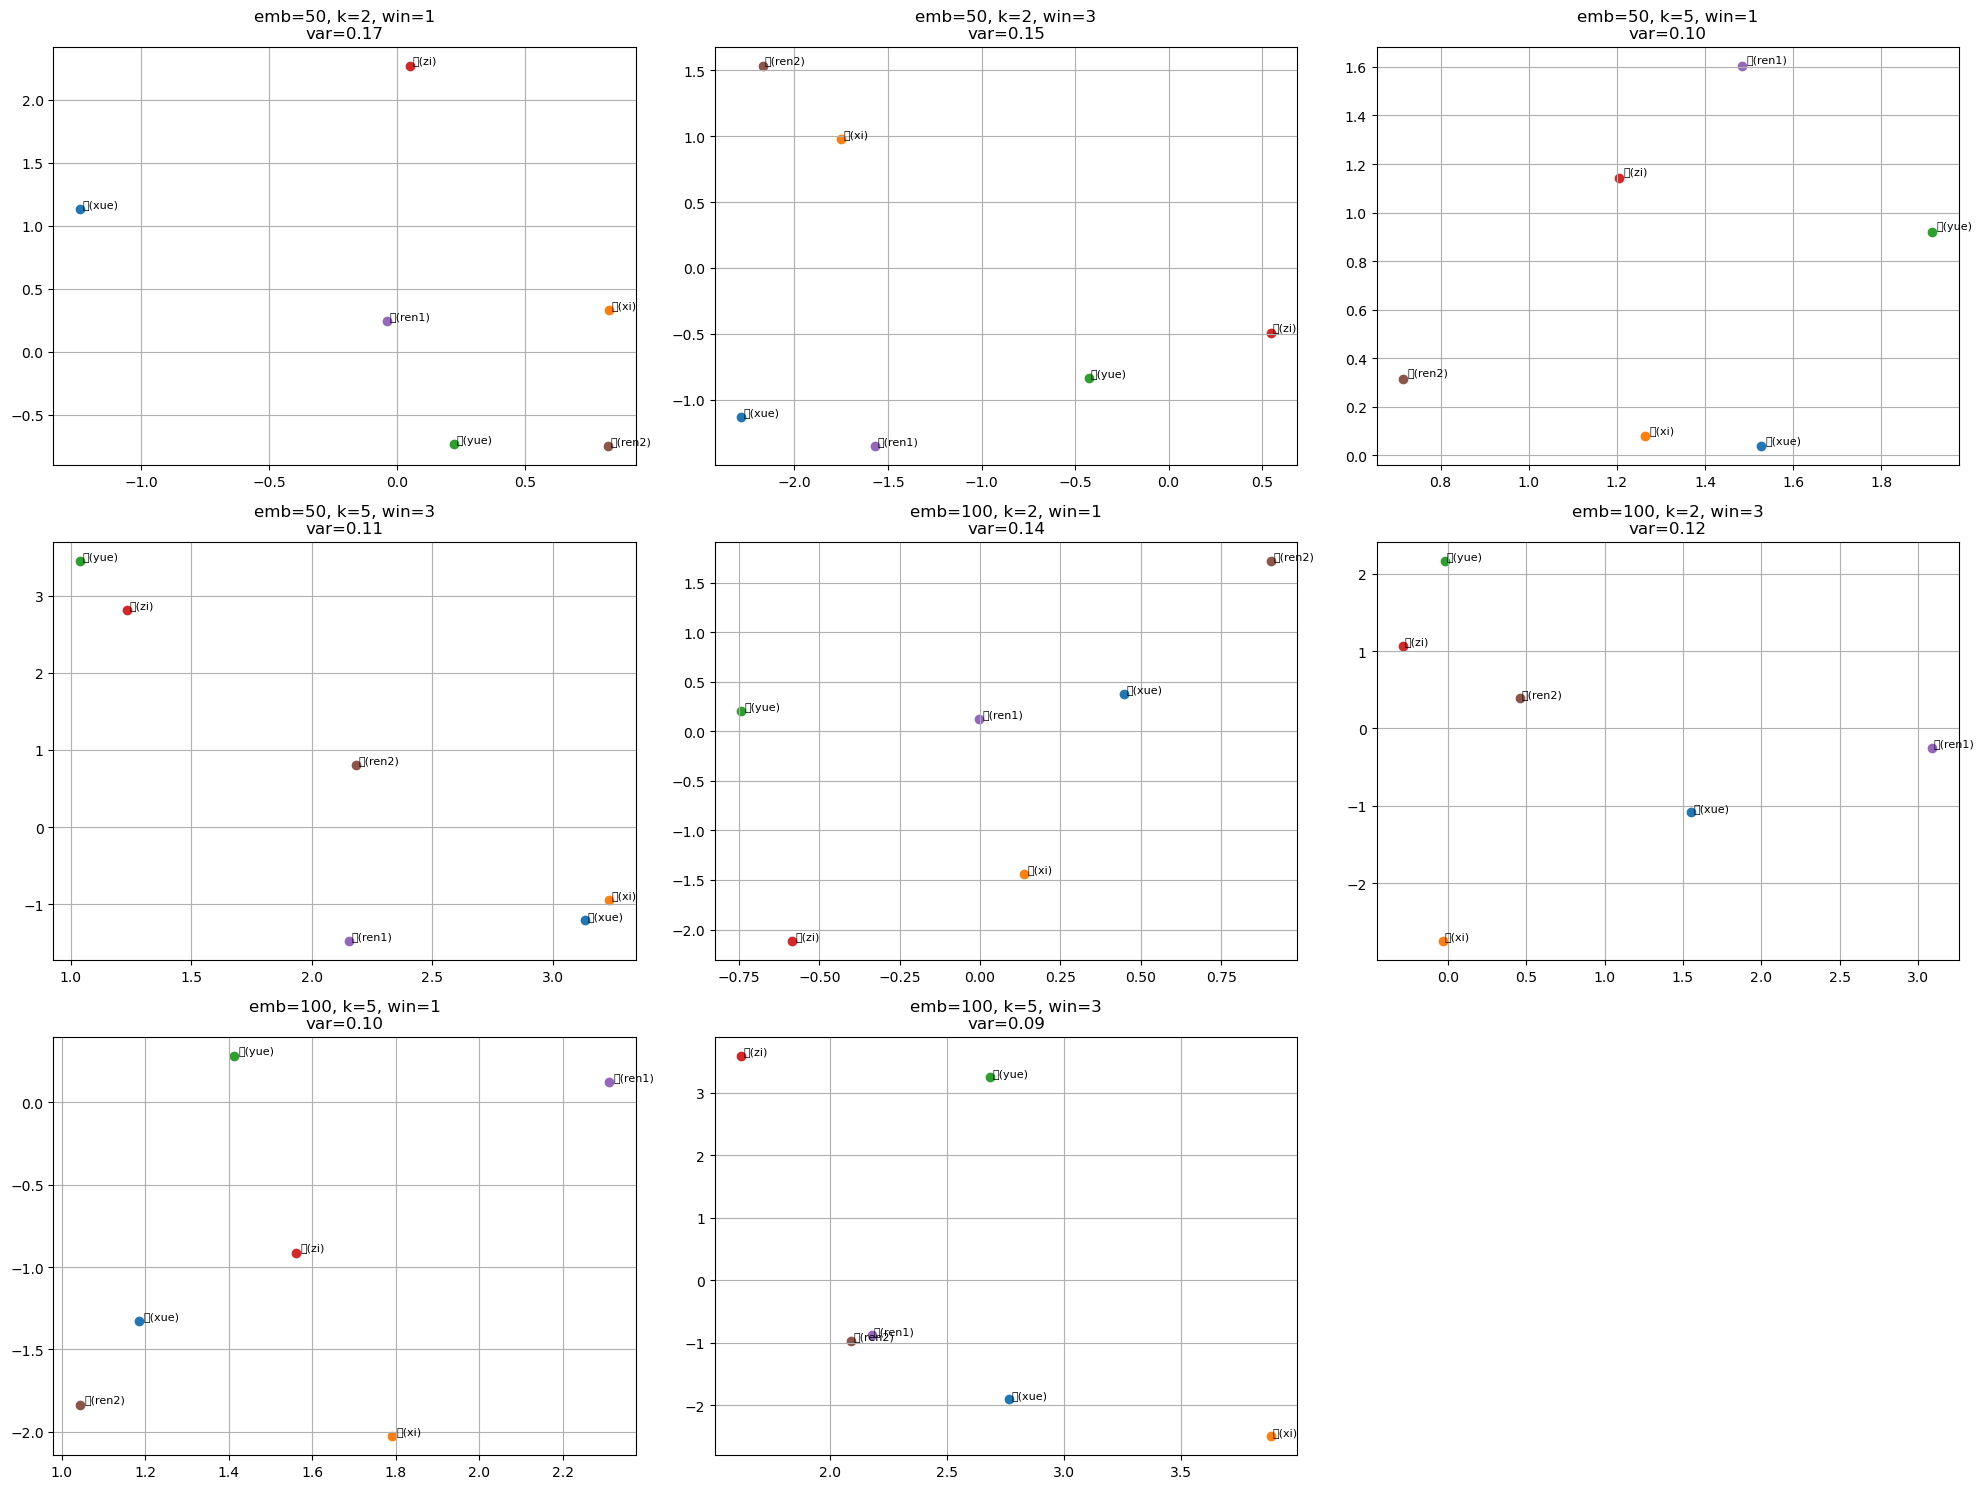

In [19]:
# 定义所有参数组合
combinations = [
    {'emb_size': 50, 'k': 2, 'window_size': 1},
    {'emb_size': 50, 'k': 2, 'window_size': 3},
    {'emb_size': 50, 'k': 5, 'window_size': 1},
    {'emb_size': 50, 'k': 5, 'window_size': 3},
    {'emb_size': 100, 'k': 2, 'window_size': 1},
    {'emb_size': 100, 'k': 2, 'window_size': 3},
    {'emb_size': 100, 'k': 5, 'window_size': 1},
    {'emb_size': 100, 'k': 5, 'window_size': 3},
]

# 存储所有实验结果
results = []

# 读取原始文本并分词（确保这步正确执行）
with open("lunyu_20chapters.txt", 'r', encoding='utf-8') as f:
    text = f.read()
    # 对中文文本按字符分词
    words = list(text.replace('\n', '').replace(' ', ''))
    # 过滤掉不在词典中的词
    words = [word for word in words if word in corpus.word2id]
print(f"处理后的总词数: {len(words)}")

# 对每个参数组合进行训练
for params in combinations:
    print(f"\n训练参数: {params}")
    
    # 初始化模型和优化器
    model = SkipGram(vocab_size, params['emb_size'])
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
    
    try:
        # 训练模型
        losses = train(model, words, corpus, batch_size, params['window_size'], 
                      params['k'], optimizer, scheduler, epochs=10, 
                      device=device, print_interval=100)
        
        # 保存模型和结果
        output_file = f"embeddings_emb{params['emb_size']}_k{params['k']}_win{params['window_size']}.txt"
        model.save_embedding(corpus.id2word, output_file)
        
        # 获取嵌入向量
        embeddings = model.emb_v.weight.detach().cpu().numpy()
        
        # 使用TruncatedSVD降维
        svd = TruncatedSVD(n_components=2)
        embeddings_2d = svd.fit_transform(embeddings)
        
        # 存储结果
        results.append({
            'params': params,
            'embeddings_2d': embeddings_2d,
            'explained_variance': svd.explained_variance_ratio_.sum()
        })
        
    except Exception as e:
        print(f"训练失败: {e}")
        continue

# 只有当有结果时才绘图
if results:
    # 绘制所有结果
    plt.figure(figsize=(20, 15))
    words = ['学', '习', '曰', '子', '人', '仁']
    words_pinyin = ['xue', 'xi', 'yue', 'zi', 'ren1', 'ren2']

    for i, result in enumerate(results):
        plt.subplot(3, 3, i+1)
        
        # 获取目标词的索引和对应的2D坐标
        for word, pinyin in zip(words, words_pinyin):
            if word in corpus.word2id:
                idx = corpus.word2id[word]
                x, y = result['embeddings_2d'][idx]
                plt.scatter(x, y, marker='o')
                plt.text(x+0.01, y+0.01, f"{word}({pinyin})", fontsize=8)
        
        params = result['params']
        plt.title(f"emb={params['emb_size']}, k={params['k']}, win={params['window_size']}\n" + 
                 f"var={result['explained_variance']:.2f}")
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('embeddings_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()